In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np



In [2]:
from torchvision import utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [4]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path_train = '/content/drive/MyDrive/project_data/train'
path_valid = '/content/drive/MyDrive/project_data/validation'
path_test = '/content/drive/MyDrive/project_data/test'

## 영상데이터에 대한 전처리과정 정의하기

In [6]:
train_transforms = transforms.Compose(
      [
          transforms.Grayscale(num_output_channels=3),
          transforms.Resize((64,64)),
          transforms.ToTensor(),
      ]
    )

## ImageFolder를 활용하여 data loader를 생성하기

In [7]:
batch_size = 32

trainset = torchvision.datasets.ImageFolder(root = path_train,transform=train_transforms)
validset = torchvision.datasets.ImageFolder(root = path_valid,transform=train_transforms)
testset = torchvision.datasets.ImageFolder(root = path_test,transform=train_transforms)

trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
validloader = torch.utils.data.DataLoader(validset,batch_size=batch_size,shuffle=False)
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)

In [8]:
tgtnames = trainset.classes
print(tgtnames)

['MBD', 'normal']


In [9]:
print(len(trainset),len(validset), len(testset))

460 102 101


torch.Size([32, 3, 64, 64])
torch.Size([32])


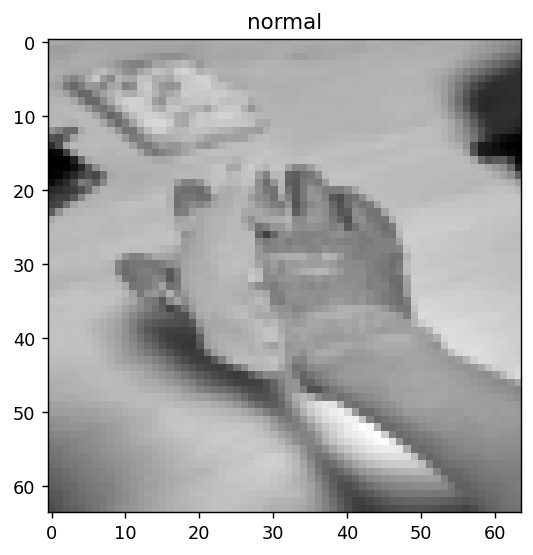

In [10]:
for X, y in trainloader:
  print(X.shape)
  print(y.shape)
  I = X[0][0].numpy()
  plt.figure(dpi=128)
  plt.imshow(I,cmap='gray')
  plt.title(tgtnames[y[0]])
  plt.show()
  break

## ResNet50 모델을 정의해보기

In [11]:
# load resnet50 with the pre-trained weights
from torchvision import models
import torch

resnet50_pretrained = models.resnet50(pretrained=True)
resnet50_pretrained = resnet50_pretrained.to(device)
print(resnet50_pretrained)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
import torchsummary

torchsummary.summary(resnet50_pretrained, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

## Hyperparameter의 설정

In [13]:
# setting hyper-parameters
learning_rate = .1
num_epochs = 100

# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(resnet50_pretrained.parameters(),lr=learning_rate) # sgd

## Model 학습 진행

In [14]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])
accs_test = np.array([])

for epoch in range(num_epochs):
    i=0
    l_epoch = 0
    correct = 0
    resnet50_pretrained.train()
    for X,y in trainloader:
        i=i+1
        X,y = X.to(device),y.to(device)
        y_hat=resnet50_pretrained(X)
        correct += (y_hat.argmax(dim=1)==y).sum()
        l=loss(y_hat,y)
        l_epoch+=l
        alg.zero_grad()
        l.backward()
        alg.step()

    loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
    accs_train = np.append(accs_train,correct.cpu()/len(trainset))

    correct = 0
    resnet50_pretrained.eval()
    for X,y in validloader:
        X,y = X.to(device),y.to(device)
        y_hat = resnet50_pretrained(X)
        correct += (y_hat.argmax(dim=1)==y).sum()

    accs_valid = np.append(accs_valid,correct.cpu()/len(validset))


    if epoch%5 == 0:
        print('epoch: %d '%(epoch))
        print('train loss: ',loss_train[-1])
        print('train accuracy: ',accs_train[-1])
        print('valid accuracy: ',accs_valid[-1])

epoch: 0 
train loss:  4.161946360270182
train accuracy:  0.554347813129425
valid accuracy:  0.656862735748291
epoch: 5 
train loss:  0.9329643885294596
train accuracy:  0.6108695864677429
valid accuracy:  0.6372548937797546
epoch: 10 
train loss:  0.5684183756510417
train accuracy:  0.72826087474823
valid accuracy:  0.6372548937797546
epoch: 15 
train loss:  0.3950481096903483
train accuracy:  0.834782600402832
valid accuracy:  0.7450980544090271
epoch: 20 
train loss:  0.44150304794311523
train accuracy:  0.8152173757553101
valid accuracy:  0.656862735748291
epoch: 25 
train loss:  0.12887168725331624
train accuracy:  0.949999988079071
valid accuracy:  0.7745097875595093
epoch: 30 
train loss:  0.0784302552541097
train accuracy:  0.980434775352478
valid accuracy:  0.7843137383460999
epoch: 35 
train loss:  0.052353501319885254
train accuracy:  0.9760869741439819
valid accuracy:  0.8039215803146362
epoch: 40 
train loss:  0.038173115253448485
train accuracy:  0.991304337978363
valid a

In [15]:
#test Accuracy 평균값
correct = 0
resnet50_pretrained.eval()

for X,y in testloader:
    X,y = X.to(device),y.to(device)
    y_hat = resnet50_pretrained(X)
    correct += (y_hat.argmax(dim=1)==y).sum()

accs_test = np.append(accs_test,correct.cpu()/len(testset))
print(f"Test Accuracy: ", accs_test[0])


Test Accuracy:  0.8712871074676514


In [31]:
train_accuracy_list = [0.554347813129425, 0.6108695864677429, 0.72826087474823, 0.834782600402832, 0.8152173757553101, 0.949999988079071, 0.980434775352478, 0.9760869741439819, 0.991304337978363, 1.0, 1.0, 0.997826099395752, 0.9847826361656189, 1.0, 0.997826099395752, 0.997826099395752, 1.0, 0.936956524848938, 0.9934782385826111, 1.0]
valid_accuracy_list = [0.656862735748291, 0.6372548937797546, 0.6372548937797546, 0.7450980544090271, 0.656862735748291, 0.7745097875595093, 0.7843137383460999, 0.8039215803146362, 0.6960784196853638, 0.7843137383460999, 0.7843137383460999, 0.7647058963775635, 0.47058823704719543, 0.813725471496582, 0.813725471496582, 0.8039215803146362, 0.7647058963775635, 0.7941176295280457, 0.7843137383460999, 0.7647058963775635]

train_accuracy_mean = sum(train_accuracy_list) / len(train_accuracy_list)
valid_accuracy_mean = sum(valid_accuracy_list) / len(valid_accuracy_list)

print("Train accuracy mean:", train_accuracy_mean)
print("Valid accuracy mean:", valid_accuracy_mean)

Train accuracy mean: 0.9175000011920929
Valid accuracy mean: 0.736764706671238


## 학습과정의 요약

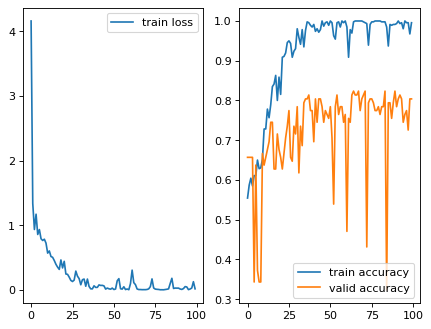

In [17]:
plt.figure(2,dpi=80)
plt.subplot(121)
plt.plot(loss_train,label='train loss')
plt.legend(loc='upper right')
plt.subplot(122)
plt.plot(accs_train,label='train accuracy')
plt.plot(accs_valid,label='valid accuracy')
plt.legend(loc='lower right')
plt.show()

In [18]:
import pickle
with open("resnet_binary.pkl", "wb") as f:
    pickle.dump(resnet50_pretrained, f)

In [19]:
torch.save(resnet50_pretrained, 'resnet_binary2.pkl')

## Validation set에 대한 개별결과 확인 (Inference)

In [20]:
from PIL import Image

In [21]:
N = 51
#validset.imgs[N][0]

normal


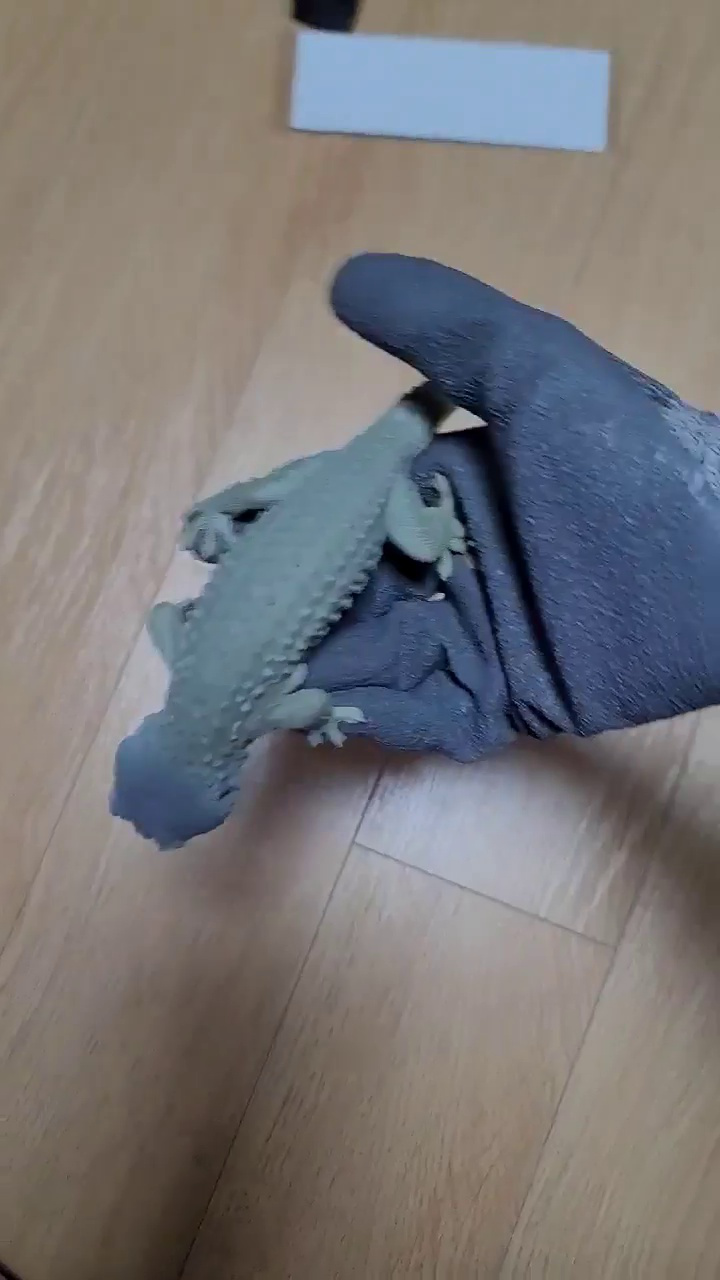

In [22]:
I = Image.open(validset.imgs[N][0])
X = train_transforms(I)
y = validset.targets[N]

print(tgtnames[y])
I


## Validation set에 대한 결과 요약하기

In [23]:
y_list = np.array([])
y_hat_list = np.array([])
for X,y in validloader:
  y_hat = resnet50_pretrained(X.to(device))    
  y_hat = y_hat.argmax(dim=1)
  y_list = np.append(y_list,y)
  y_hat_list = np.append(y_hat_list,y_hat.cpu().numpy())

In [24]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)

In [25]:
print(classification_report(
    y_list,
    y_hat_list,
    target_names=tgtnames))

              precision    recall  f1-score   support

         MBD       0.76      0.63      0.69        35
      normal       0.82      0.90      0.86        67

    accuracy                           0.80       102
   macro avg       0.79      0.76      0.77       102
weighted avg       0.80      0.80      0.80       102



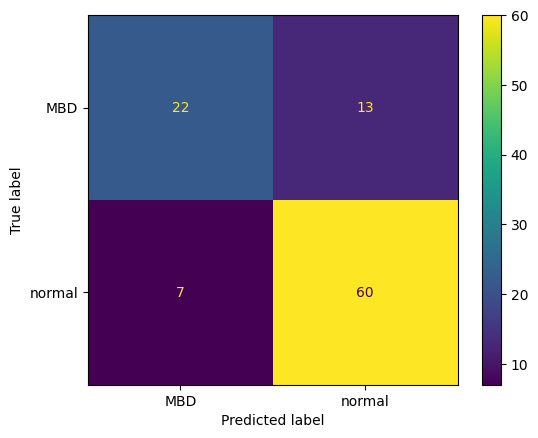

In [26]:
cm = confusion_matrix(
    y_list,
    y_hat_list,
#    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=tgtnames,
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

## Test set에 대한 결과 요약하기

In [27]:


y_list = np.array([])
y_hat_list = np.array([])
for X,y in testloader:
  y_hat = resnet50_pretrained(X.to(device))    
  y_hat = y_hat.argmax(dim=1)
  y_list = np.append(y_list,y)
  y_hat_list = np.append(y_hat_list,y_hat.cpu().numpy())

In [28]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)

In [29]:


print(classification_report(
    y_list,
    y_hat_list,
    target_names=tgtnames))

              precision    recall  f1-score   support

         MBD       0.70      0.79      0.75        24
      normal       0.93      0.90      0.91        77

    accuracy                           0.87       101
   macro avg       0.82      0.84      0.83       101
weighted avg       0.88      0.87      0.87       101



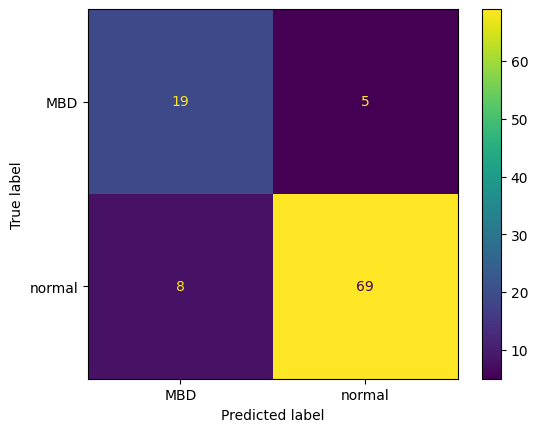

In [30]:
cm = confusion_matrix(
    y_list,
    y_hat_list,
#    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=tgtnames,
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])